# License setup

In [ ]:
# first step everytime you need to run

import json
import os
# Upload your spark_nlp_for_healthcare.json  to the default directory and then run this cell to authenticate 
with open('4.3.0.spark_nlp_for_healthcare.json', 'r') as f:
    for k, v in json.load(f).items():
        %set_env $k=$v

#%set_env PYSPARK=3.2.1
# %set_env SPARK_HOME=/home/ec2-user/SageMaker/spark-3.2.2-bin-hadoop2.7

with open('4.3.0.spark_nlp_for_healthcare.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)


!java -version

# Library setup

In [2]:
# Installing Spark NLP Healthcare
%pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Installing Spark OCR
%pip install --upgrade -q spark-ocr==$OCR_VERSION --extra-index-url=https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET

# Installing pyspark and spark-nlp
%pip install --upgrade -q pyspark==3.2.1 spark-nlp==$PUBLIC_VERSION

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip show pyspark

Name: pyspark
Version: 3.2.1
Summary: Apache Spark Python API
Home-page: https://github.com/apache/spark/tree/master/python
Author: Spark Developers
Author-email: dev@spark.apache.org
License: http://www.apache.org/licenses/LICENSE-2.0
Location: /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages
Requires: py4j
Required-by: sagemaker-pyspark, spark-ocr
Note: you may need to restart the kernel to use updated packages.


In [4]:
%set_env SPARK_HOME= /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark

env: SPARK_HOME=/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark


In [5]:
import numpy
numpy.__version__

'1.21.6'

In [6]:
%pip install --upgrade scikit-image

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Using cached scikit_image-0.19.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.9 MB)
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.1
    Uninstalling scikit-image-0.18.1:
      Successfully uninstalled scikit-image-0.18.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spark-ocr 4.3.1 requires scikit-image==0.18.1, but you have scikit-image 0.19.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [7]:
import skimage
skimage.__version__

'0.19.3'

In [8]:
%pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com, https://download.pytorch.org/whl/cu113
Note: you may need to restart the kernel to use updated packages.


# Start Session 

In [9]:
import sys, os
import base64

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import sparkocr
from sparkocr import start
from sparkocr.enums import *
from sparkocr.utils import *
from sparkocr.metrics import score
from sparkocr.transformers import *

import sparknlp
import sparknlp_jsl

from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline, PipelineModel

import pkg_resources

# Start spark
spark = sparkocr.start(secret=SPARK_OCR_SECRET, 
                       nlp_version=PUBLIC_VERSION,
                       nlp_secret=SECRET,
                       nlp_internal=JSL_VERSION
                       )
spark

spark.sparkContext.setLogLevel("ERROR")

# check that spark started
spark

Spark version: 3.2.1
Spark NLP version: 4.3.0
Spark NLP for Healthcare version: 4.3.0
Spark OCR version: 4.3.1



23/02/28 12:01:58 INFO LicenseValidator$: Using com.johnsnowlabs.license.AirGapped license, cannot start periodic credential refresh.
23/02/28 12:01:58 INFO LicenseValidator$: Using com.johnsnowlabs.license.AirGapped license, cannot start periodic credential refresh.


# pip

In [10]:
def deidentification_nlp_pipeline(input_column, prefix = ""):
    document_assembler = DocumentAssembler() \
        .setInputCol(input_column) \
        .setOutputCol(prefix + "document")

    # Sentence Detector annotator, processes various sentences per line
    sentence_detector = SentenceDetector() \
        .setInputCols([prefix + "document"]) \
        .setOutputCol(prefix + "sentence")

    tokenizer = Tokenizer() \
        .setInputCols([prefix + "sentence"]) \
        .setOutputCol(prefix + "token")

    # Clinical word embeddings
    word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token"]) \
        .setOutputCol(prefix + "embeddings")
    # NER model trained on i2b2 (sampled from MIMIC) dataset
    clinical_ner = MedicalNerModel.pretrained("ner_deid_large", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "embeddings"]) \
        .setOutputCol(prefix + "ner")

    custom_ner_converter = NerConverterInternal() \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "ner"]) \
        .setOutputCol(prefix + "ner_chunk") \
        .setWhiteList(['NAME', 'AGE', 'CONTACT', 'LOCATION', 'PROFESSION', 'PERSON', 'DATE'])

    nlp_pipeline = Pipeline(stages=[
            document_assembler,
            sentence_detector,
            tokenizer,
            word_embeddings,
            clinical_ner,
            custom_ner_converter
        ])
    empty_data = spark.createDataFrame([[""]]).toDF(input_column)
    nlp_model = nlp_pipeline.fit(empty_data)
    return nlp_model

In [11]:
# Read Pdf as image
pdf_to_image = PdfToImage()\
    .setInputCol("content")\
    .setOutputCol("image_raw")\
    .setResolution(400)

# Extract text from image
ocr = ImageToText() \
    .setInputCol("image_raw") \
    .setOutputCol("text") \
    .setIgnoreResolution(False) \
    .setPageIteratorLevel(PageIteratorLevel.SYMBOL) \
    .setPageSegMode(PageSegmentationMode.SPARSE_TEXT) \
    .setWithSpaces(True) \
    .setConfidenceThreshold(70)

hocr = ImageToHocr() \
    .setInputCol("image_raw") \
    .setOutputCol("hocr") \
    .setIgnoreResolution(False) \
    .setOcrParams(["preserve_interword_spaces=0"])\
    .setPageIteratorLevel(PageIteratorLevel.SYMBOL)\
    .setPageSegMode(PageSegmentationMode.SPARSE_TEXT) \

# Found coordinates of sensitive data
position_finder = PositionFinder() \
    .setInputCols("ner_chunk") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions") \
    .setMatchingWindow(100) \
    .setPadding(1)

# Draw filled rectangle for hide sensitive data
drawRegions = ImageDrawRegions()  \
    .setInputCol("image_raw")  \
    .setInputRegionsCol("coordinates")  \
    .setOutputCol("image_with_regions")  \
    .setFilledRect(True) \
    .setRectColor(Color.black)
    
# OCR pipeline
deid_pipeline = PipelineModel(stages=[
    pdf_to_image,
    ocr,
    hocr,
    deidentification_nlp_pipeline(input_column="text"),
    position_finder,
    drawRegions
])

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[ | ]embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
Download done! Loading the resource.
[OK!]
ner_deid_large download started this may take some time.
[ | ]ner_deid_large download started this may take some time.
Approximate size to download 14.1 MB
Download done! Loading the resource.
[OK!]


In [19]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/ocr/MT_00.pdf -P deid/


In [20]:
file_path='./deid/*.pdf'
pdfs = spark.read.format("binaryFile").load(file_path)
pdfs.show()

+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/home/ec2-us...|2023-02-28 12:04:...|528022|[25 50 44 46 2D 3...|
+--------------------+--------------------+------+--------------------+



In [21]:
deid_results = deid_pipeline.transform(pdfs)# .cache()

deid_results.select("ner_chunk").show(truncate=100)

+----------------------------------------------------------------------------------------------------+
|                                                                                           ner_chunk|
+----------------------------------------------------------------------------------------------------+
|[{chunk, 120, 129, 2093-01-13, {chunk -> 0, confidence -> 1.0, ner_source -> ner_chunk, entity ->...|
|[{chunk, 208, 221, US Post Office, {chunk -> 0, confidence -> 0.5585334, ner_source -> ner_chunk,...|
|[{chunk, 28, 37, March 2006, {chunk -> 0, confidence -> 0.96885, ner_source -> ner_chunk, entity ...|
+----------------------------------------------------------------------------------------------------+



In [22]:
deid_results.select('coordinates').show(truncate=100)

+----------------------------------------------------------------------------------------------------+
|                                                                                         coordinates|
+----------------------------------------------------------------------------------------------------+
|[{0, 0, 693.0, 1013.0, 272.0, 40.0, 0.0, 0, 0.0}, {1, 0, 1011.0, 1009.0, 253.0, 44.0, 0.0, 0, 0.0...|
|[{0, 1, 1189.0, 910.0, 335.0, 44.0, 0.0, 0, 0.0}, {1, 1, 1328.0, 1153.0, 607.0, 56.0, 0.0, 0, 0.0...|
|[{0, 2, 1027.0, 593.0, 255.0, 48.0, 0.0, 0, 0.0}, {1, 2, 1920.0, 1096.0, 455.0, 56.0, 0.0, 0, 0.0...|
+----------------------------------------------------------------------------------------------------+



In [23]:
!wget -q -O jsl_utils.py https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/utils/jsl_utils.py

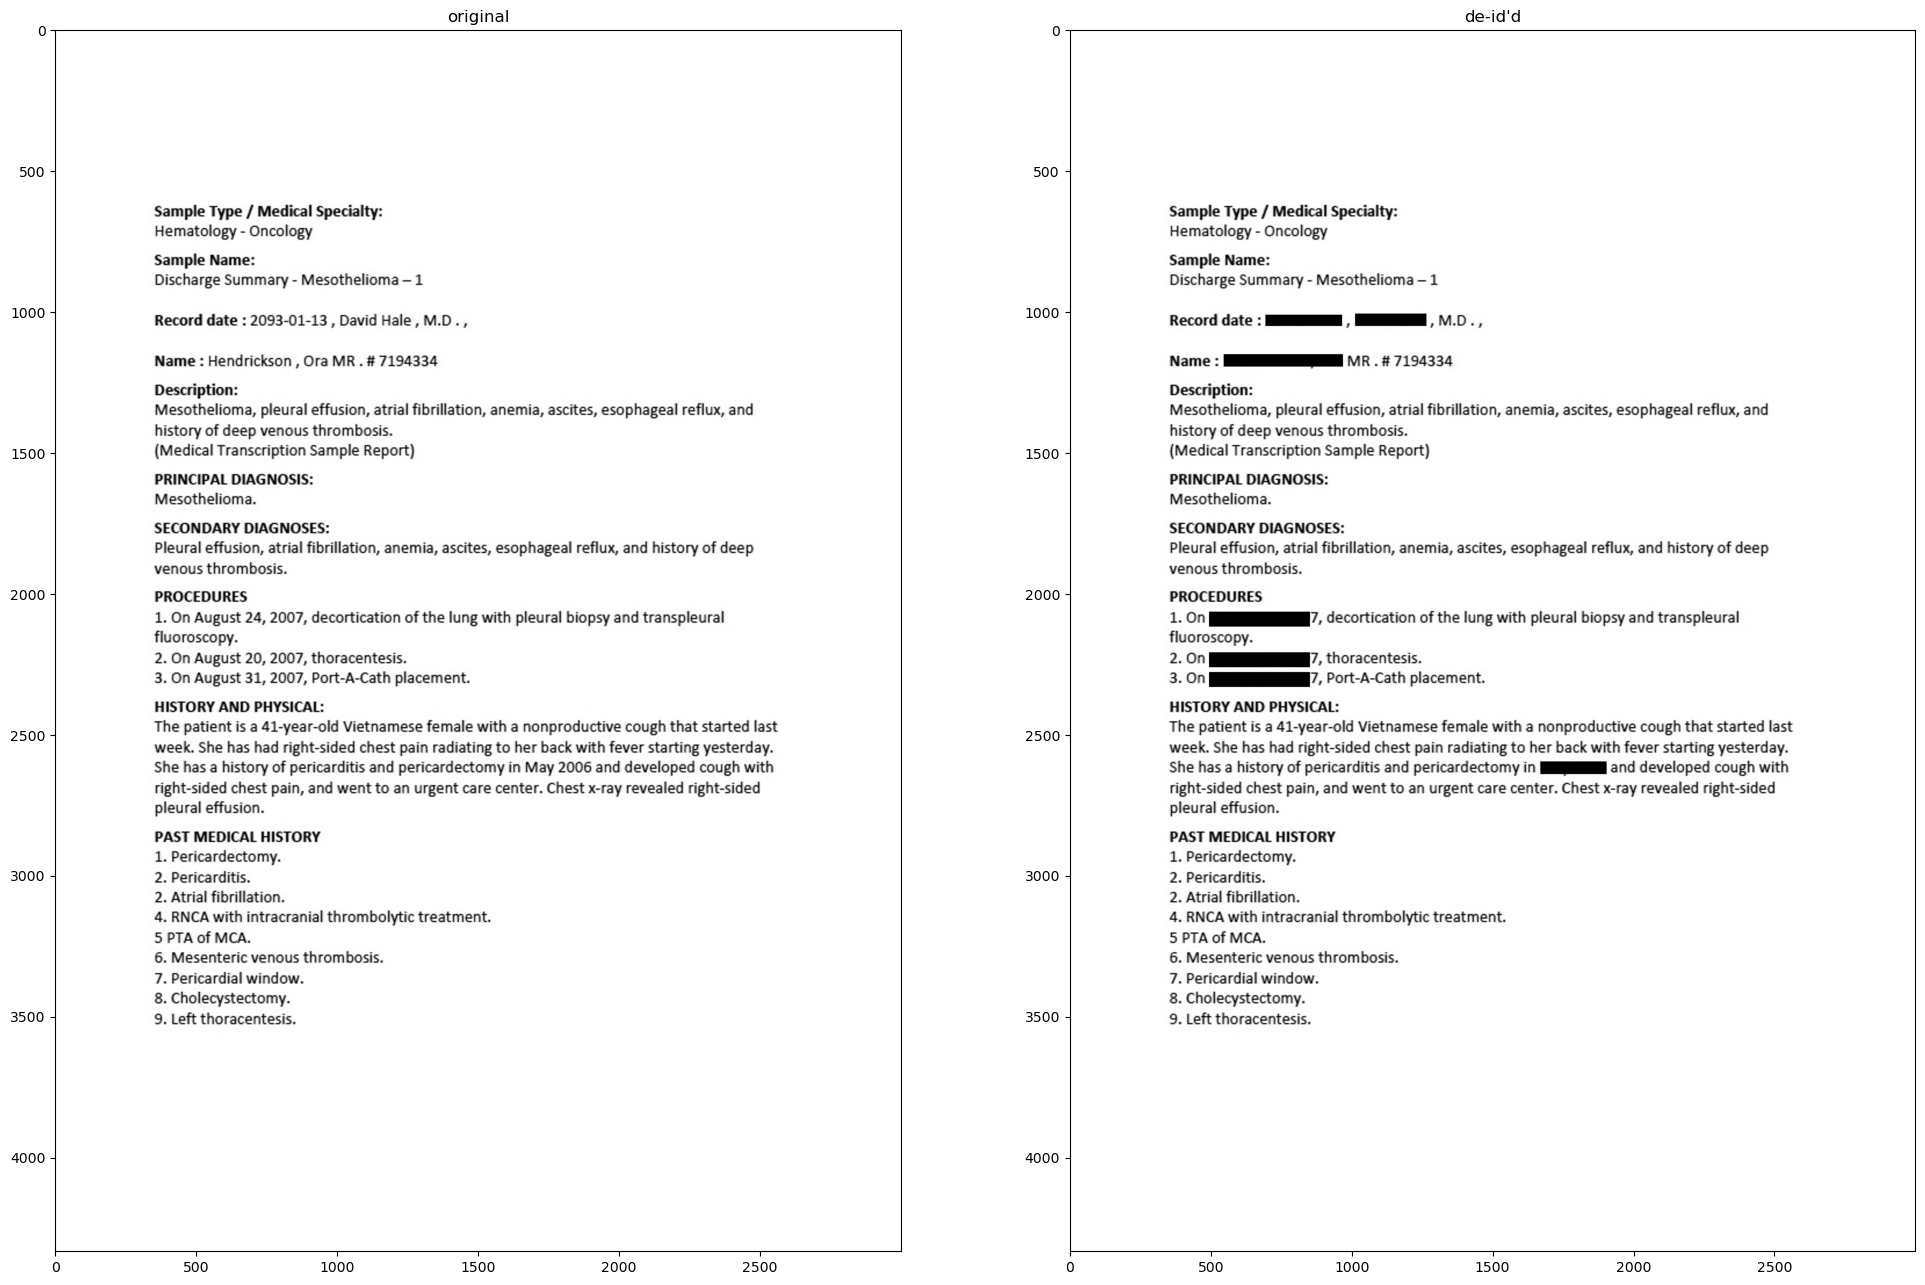

In [24]:
from sparkocr.utils import display_image, to_pil_image
import matplotlib.pyplot as plt

r = deid_results.select("image_raw", "image_with_regions").collect()[0]
img_orig = r.image_raw
img_deid = r.image_with_regions

img_pil_orig = to_pil_image(img_orig, img_orig.mode)
img_pil_deid = to_pil_image(img_deid, img_deid.mode)

plt.figure(figsize=(24,16))
plt.subplot(1, 2, 1)
plt.imshow(img_pil_orig, cmap='gray')
plt.title('original')
plt.subplot(1, 2, 2)
plt.imshow(img_pil_deid, cmap='gray')
plt.title("de-id'd")
plt.show()